In [94]:
import numpy as np

In [95]:
import seaborn as sns

custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 1.25,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif"}
sns.set_theme(context = "notebook", style="ticks", rc=custom_params) 

In [96]:
bead_density = 1055
water_density = 1000
bead_size = 0.055e-6
particle_volume = 4/3 * np.pi * (bead_size)**3
bead_mass = (bead_density - water_density) * particle_volume


print(f"Bead buoyant mass : {bead_mass:.2e} kg")



kB = 1.380649e-23
T = 300
g = 9.81
g = 5_000*g

Boltzmann_length = kB*T/(bead_mass*g)

print(f"Boltzmann length : {Boltzmann_length:.2e} m")

Debye_length = 60e-9
B = 4

evanescence = 500e-9
H = 5e-6 # ?
L = 25e-6 #?
W = 25e-6 #?
canal_volume_total = H * L * W
print(f"Total canal volume : {canal_volume_total:.2e} m^3")

phi = 1e-4
N_tot_particles = phi * canal_volume_total / particle_volume

print(f"N_tot_particles : {N_tot_particles:.2e}")

slice_volume = evanescence * L * W
N_slice_particles = phi * slice_volume / particle_volume
print(f"N_slice_particles : {N_slice_particles:.2e}")

ratio_particles = N_tot_particles/N_slice_particles

print(
    f"For a canal of dimensions L={L:.2e}, W={W:.2e}, H={H:.2e}, \n and an evanescent slice of height {evanescence:.2e},\n expect {ratio_particles:.2e} times more particles.")

Bead buoyant mass : 3.83e-20 kg
Boltzmann length : 2.20e-06 m
Total canal volume : 3.13e-15 m^3
N_tot_particles : 4.48e+02
N_slice_particles : 4.48e+01
For a canal of dimensions L=2.50e-05, W=2.50e-05, H=5.00e-06, 
 and an evanescent slice of height 5.00e-07,
 expect 1.00e+01 times more particles.


## Calculating the Gibbz Boltzmann distribution

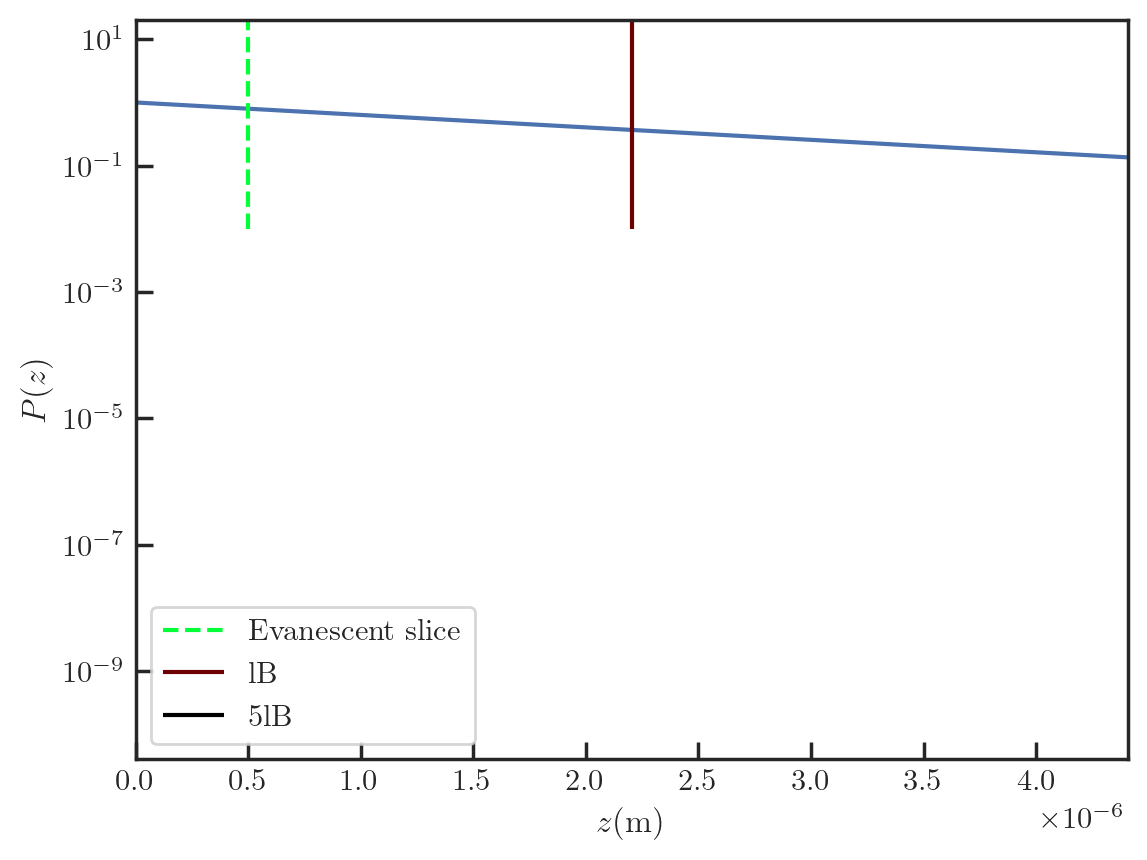

In [101]:
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

cell_height = np.linspace(0, max(10*H, 10*Boltzmann_length), 100000)


P_eq_nonorm = np.exp(-( cell_height/Boltzmann_length)) #np.exp(-(B * np.exp(-cell_height/Debye_length) + cell_height/Boltzmann_length))

P_eq_norm = P_eq_nonorm / trapezoid(P_eq_nonorm, cell_height)

plt.semilogy(cell_height, P_eq_nonorm)
plt.vlines(5e-7, 1e-2, 1e6, color = "#00FF37", linestyle = "--", label = "Evanescent slice")
plt.vlines(Boltzmann_length, 1e-2, 1e6, color = "#6D0000", label = "lB")

plt.vlines(5*Boltzmann_length, 1e-2, 1e6, color = '#000000', label = "5lB")

plt.xlabel("$z$(m)")
plt.ylabel("$P(z)$")

plt.xlim(0, 2*Boltzmann_length)

plt.legend()

plt.show()

In [98]:
Boltzmann_length

2.203059153601026e-06

The decay is exponentially small beyond lB. Thus, we can expect the concentration to remain constant provided we chose a lB superior to the evanescence slice height.

REMINDER : launch positions from equilibrium sampling.

I just have to fill with particles until about 5lBs, and wait it out for the system to thermalise. Then, I can lunch the simulations.

## RECAP : How many particles and what size of canal to use

In [99]:
phi_min = 3e-5
phi_max = 3e-4
phi_range = np.array((phi_min, phi_max))

until_five_lB = cell_height <= 4.7 * Boltzmann_length
N_fivelB = trapezoid(P_eq_norm[until_five_lB], cell_height[until_five_lB])
print(N_fivelB) ## 99% of particles inculded below this, let's say it's phi_0.
# 99% below 5lb.
# 98% below 4lb.
# 94% below 3lb.

until_lambda = cell_height <= evanescence
N_lambda = trapezoid(P_eq_norm[until_lambda], cell_height[until_lambda])
print(N_lambda) ## 60 % below this

new_initial_phi_range = phi_range * evanescence / (N_lambda * 4 * Boltzmann_length)

print(f"Thus, the initial concentration of particles within a 5lB slab shall be", new_initial_phi_range, ".")




0.9909035897777629
0.20286597148656219
Thus, the initial concentration of particles within a 5lB slab shall be [8.39065577e-06 8.39065577e-05] .


That means I can work with quite dilute solutions while still minimising further dilution.

Next step :

I'll now initiate the simulations by launching positions at random, letting thermalisation do its thing, and then launch the shear.

Step 1 : Initialisation.
Define a 5 lB tall box with an open vertical boundary in y and PBC on x and z.
Fill box with random particle positions.
Apply g along y and thermalise.
Recover positions after MSDs are stable and steady (I am expecting a plateau due to weak gravitational confinement).


Step 2 : Simulation.
Apply a shear to the whole system.
(Sanity check here : plot some trajectories)
Retrieve all y-DISPLACEMENTS.
If a trajectory exits the box OB : end of trajectory.
If a trajectory enters the box, or re-enters a box OB : beginning of a new trajectory.
PBC are treated as such. Anyway, we care only about vertical dispersion.




In [102]:
blob_mass_in_SI =  4/3 * np.pi *(0.055e-6)**3 * (1055 - 1000)
g = 9.81 * 1e6
kg_to_mg = 1e6
m_to_um = 1e6
blob_mass_in_weird_units =  4/3 * np.pi *(0.055)**3 * (1055 - 1000) * kg_to_mg/(m_to_um**3)

print("blob mass in normal units :", blob_mass_in_SI)
print("blob mass in units made to bring my downfall :", blob_mass_in_weird_units)
print("ratio :", blob_mass_in_SI/blob_mass_in_weird_units)

print("blob mass in 5_000g: ", 5_000 * g * blob_mass_in_weird_units)

print("ratio of gs:", blob_mass_in_SI*g/(blob_mass_in_weird_units*g*m_to_um))


blob mass in normal units : 3.8330048367673466e-20
blob mass in units made to bring my downfall : 3.833004836767346e-14
ratio : 1.0000000000000002e-06
blob mass in 5_000g:  0.0018800888724343832
ratio of gs: 1.0000000000000002e-12


To do next : recheck EVERY unit conversion.
Relaunch the thermalisation step for every value of phi.
Launch the shear step and prepare the treatment.